#1.1 Prepare our device to use Tensorflow IO




In [1]:
# to solve an error happend when using tfio
!pip uninstall tensorflow -y
!pip uninstall tensorflow-io -y
!pip uninstall tensorflow-gpu -y
#!pip install tensorflow-gpu 
#!pip install --no-deps tensorflow-io
!pip install tensorflow tensorflow-gpu tensorflow-io


Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 511.7 MB 6.3 kB/s 
     |████████████████████████████████| 25.9 MB 1.5 MB/s 
     |████████████████████████████████| 438 kB 37.6 MB/s 
     |████████████████████████████████| 1.6 MB 29.7 MB/s 
     |████████████████████████████████| 5.8 MB 29.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled

## 1.2 Importing Packages

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
import tensorflow_io as tfio
import os
from IPython.display import Audio

# 2.1 Preparing Data

## 2.2 Importing Data using Kaggle API

In [3]:
#To use kaggle API in google colab we have to make a new directory to copy our kaggle api into
! mkdir ~/.kaggle

In [4]:
# This line copy our kaggle api which should be download in your account
! cp kaggle.json ~/.kaggle/

In [5]:
# This is the api to download the dataset
!kaggle datasets download -d uldisvalainis/audio-emotions

100% 1.12G/1.12G [00:15<00:00, 66.1MB/s]
100% 1.12G/1.12G [00:15<00:00, 78.2MB/s]


## 2.3 Extracting the data after downloading it

In [6]:
#Checking if the data never been extracted before to extract it
if not os.path.exists('Emotions/'):
    with ZipFile('audio-emotions.zip','r') as z:
        z.extractall()

## 2.3 Time to load and preprocess our data

In [7]:
# To save our directory as we will use it multiple time
audio_dir = '/content/Emotions'

In [8]:
# To know our classes names and their classifications
class_names = os.listdir(audio_dir)
# It's better to save the number of classes in a variable as it's better for dynamic programming
num_classes = len(class_names)
class_names

['Happy', 'Neutral', 'Fearful', 'Disgusted', 'Sad', 'Suprised', 'Angry']

In [9]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) #sample rate is a very interesting and important topic in digital audio
                                                                              # and I encourge anyone to read about it if not
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav


> I found a lot of errors belongs to the files and a lot are corrupted, so this part of code will remove a lot of corrupted files.....


In [10]:
# This classes_dir will be used to load the files later by using Tensorflow
classes_dir = []
# To know how many files are corrupted and how many are fine to load
num_corr_file=0
norm_files = 0
for clss in class_names:
  #listed_files = tf.data.Dataset.list_files("/content/Emotions/"+clss+"/*.wav")
  # Next Block of code to remove corrupted files
  for fileName in os.listdir(f'/content/Emotions/{clss}'):
    file_path = f"/content/Emotions/{clss}/{fileName}"
    try:
      #puting the next line to omit corrupted files
      wav = load_wav_16k_mono(file_path)#---------------------------------
      norm_files += 1
    except:
      # if it throw and error, it will be catched here to remove the corrupted files
      os.remove(file_path)
      num_corr_file += 1
  #-------------------Code Block Ends Here---------------------------------
  listed_files = tf.data.Dataset.list_files(f"/content/Emotions/{clss}/*.wav")
  classes_dir.append(listed_files)
print(f"Found {num_corr_file} corrupted files and {norm_files} None corrupted files")

Found 995 corrupted files and 11803 None corrupted files


In [11]:
# Let's see how does it look like
classes_dir

[<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>]

## 2.4 Converting our data and labels into a language that Computers understands

In [33]:
# Now we need combine our data and labels into numerical 
# We have saved our files path into classes_dir, so that's our x which will be converted to a tensors later by loading it
# We will encode our labels to numbers for now so we will use a simple for loop, {i} represents our numerical labels
for i, clss in enumerate(classes_dir):
  if i == 0:
    dataset = tf.data.Dataset.zip((clss, tf.data.Dataset.from_tensor_slices(tf.repeat(i,len(clss))))) # for each file we are creating the numerical value it for it to be combined in a tuple
  else:
    data = tf.data.Dataset.zip((clss, tf.data.Dataset.from_tensor_slices(tf.repeat(i,len(clss)))))
    dataset = dataset.concatenate(data) # combining all the results

dataset

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [13]:
# We have to explore our files as they are not the same, and to decide our wave lenght "how long our sounds are"
lengths = []
for clss in class_names:
  for file in os.listdir(os.path.join(audio_dir,clss)):
    tensor_wave = load_wav_16k_mono(os.path.join(audio_dir, clss, file))
    lengths.append(len(tensor_wave))

In [14]:
len(lengths)

11803

In [15]:
print(f'Min: {tf.reduce_min(lengths)} , Max: {tf.reduce_max(lengths)}, Mean: {tf.reduce_mean(lengths)}')

Min: 20065 , Max: 114219, Mean: 41890


In [16]:
# we will take a wave lenght of 5000 "I think it's best to capture all feature we need"/ "Making it longer will take much more time to train"
wave_len = 5000

In [17]:
# This function will be used to load our data and convert it into spectogram using tensorflow dataset "Best Thing Ever!!!"
def preprocess(file_path, label):
  # Our previouse function that loads audio files
  wav = load_wav_16k_mono(file_path)
  # we will only take the first 5000 of our waves
  wav = wav[:wave_len]
  # There are files that are lower than 5000, so we have to make them all 5000 by adding Zeros to the rest of files
  zero_padding = tf.zeros([wave_len] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav],0)
  # Converting our wav files into spectogram
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

In [18]:
# We need to convert our labels to be one hot encoded using Tensorflow one_hot
def preprocess_labels(file_path,label):
  label = tf.one_hot(label, num_classes) # Which is 7
  return file_path,label

### Let's Take a look to our data

This spectogram belongs to Fearful class


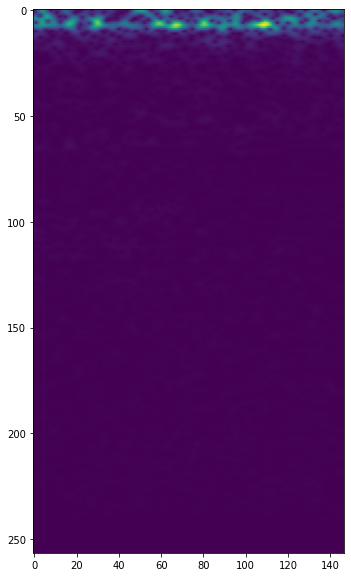

In [40]:
filepath, label = dataset.shuffle(10000).as_numpy_iterator().next()
print(f'This spectogram belongs to {class_names[label]} class')
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [42]:
# Let's hear it
from IPython import display
audio_sample = load_wav_16k_mono(filepath)
display.Audio(audio_sample,rate=16000)
# Doesn't look like a Fearful person to me

##2.5 Now to process all the dataset

In [21]:
dataset = dataset.map(preprocess_labels)
dataset = dataset.map(preprocess)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

## 2.6 Spliting our data into train, test data

In [22]:
data_len = len(dataset)
spl_siz = int(0.2*data_len)
test_data = dataset.take(spl_siz)
train_data = dataset.skip(spl_siz).take(data_len-spl_siz)
len(train_data),len(test_data)

(296, 73)

In [23]:
# Let's check our shapes
samples, labels = train_data.as_numpy_iterator().next()
samples.shape, labels.shape

((32, 147, 257, 1), (32, 7))

#3.1 Buildind our Model!

In [24]:
# Importing our liberaries
from tensorflow.keras.layers import Dropout, GlobalMaxPool2D, Dense, Conv2D, Flatten
from tensorflow.keras import Sequential

In [25]:
model = Sequential()
model.add(Conv2D(100, 2*2,activation='selu',input_shape=samples.shape[1:],name="First_Conv_Layer"))
model.add(Conv2D(100, 2*2,activation='selu',name="Second_Conv_Layer"))
model.add(Flatten(name="Flatten_Layer"))
# A dropout layer to avoid overfitting as our data isn't that big
model.add(Dropout(0.3,name="Dropout_Layer"))
model.add(Dense(num_classes, activation='softmax',name="Output_Layer"))

In [26]:
# I like to make our callbacks into a list so that it's easier to remove or add any of them
callbacks = []
# Reduces our Learning rate if there's no improvment for 5 epochs
callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=5,verbose=1))
# Stops the training if no improvement for 15 epochs and restore the best result
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=15,restore_best_weights=True))

In [27]:
lr = 0.01
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
metrics = tf.keras.metrics.Accuracy()
loss = "categorical_crossentropy" 

In [28]:
model.compile(optimizer= optimizer, loss=loss, metrics=metrics)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Conv_Layer (Conv2D)   (None, 144, 254, 100)     1700      
                                                                 
 Second_Conv_Layer (Conv2D)  (None, 141, 251, 100)     160100    
                                                                 
 Flatten_Layer (Flatten)     (None, 3539100)           0         
                                                                 
 Dropout_Layer (Dropout)     (None, 3539100)           0         
                                                                 
 Output_Layer (Dense)        (None, 7)                 24773707  
                                                                 
Total params: 24,935,507
Trainable params: 24,935,507
Non-trainable params: 0
_________________________________________________________________


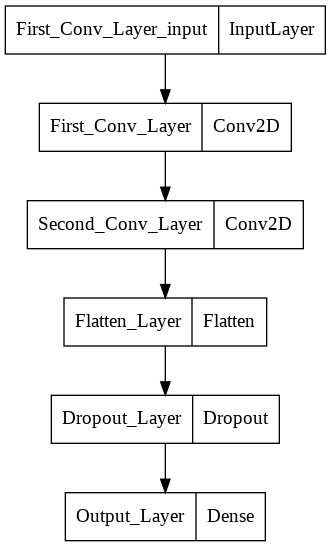

In [30]:
# I love to visualize our model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [31]:
# We are using 20% of our test data for validation data.
# It takes a very very long time to train the model so I will train it for 2 epochs which gives a good results.
history = model.fit(train_data, epochs=2, validation_data=test_data,validation_steps= int(0.2*len(test_data)),callbacks=callbacks)

Epoch 1/2
296/296 [==============================] - 8690s 29s/step - loss: 11195.8975 - accuracy: 0.7850 - val_loss: 24605.2188 - val_accuracy: 0.7124 - lr: 0.0100
Epoch 2/2
296/296 [==============================] - 8569s 29s/step - loss: 4889.8848 - accuracy: 0.8029 - val_loss: 7745.5693 - val_accuracy: 0.7124 - lr: 0.0100


## 3.3 Evaluating our model

In [32]:
model.evaluate(test_data)

73/73 [==============================] - 564s 8s/step - loss: 6434.5122 - accuracy: 0.7105


[6434.51220703125, 0.7104941010475159]